In [161]:
import pandas as pd
from ast import literal_eval
import numpy as np
from sklearn.decomposition import PCA
from argparse import ArgumentParser
import yaml

with open("config.yaml", 'r') as f:
    try:
        config = yaml.safe_load(f)
    except:
        print("Could not load yaml config")
        exit()


def scale_value(val, minval, maxval):
    return((((val - minval)/(maxval-minval)) * (255-0)) + 0)

def rgb_to_int(rgb, current_min, current_max):
    # Scale the values first
    scaled_rgb_0 = scale_value(rgb[0], current_min[0], current_max[0])
    scaled_rgb_1 = scale_value(rgb[1], current_min[1], current_max[1])
    scaled_rgb_2 = scale_value(rgb[2], current_min[2], current_max[2])
    return(int(scaled_rgb_0), int(scaled_rgb_1), int(scaled_rgb_2))

def create_viz_column(list_feat_scores, compressed_feat, lines):
    pca_model = compressed_feat.get('model')
    current_min = compressed_feat.get('min') 
    current_max = compressed_feat.get('max')
    list_df = convert_list_to_df(list_feat_scores)
    exp_cols = compressed_feat.get('exp_cols')
    list_df = pd.concat([list_df, pd.DataFrame([[0] * len(exp_cols)]*(int(config.get('last_n'))-len(list_df)), columns=exp_cols)], sort=False, axis=0, ignore_index=True)
    list_df.fillna(0.0, inplace=True)
    rgb_val_col = [rgb_to_int(rgb, current_min, current_max) for rgb in pca_model.transform(list_df)]
    return(rgb_val_col)

def convert_list_to_df(x):
    x = literal_eval(x)
    x_df = pd.DataFrame(x)
    x_df.fillna(0.0, inplace=True)
    x_df.reset_index(drop=True, inplace=True)
    return(x_df)


def compress_for_visualization(pd_series):
    all_feat_df = pd.concat([convert_list_to_df(feat_list) for feat_list in pd_series], sort=False, axis=0, ignore_index=True)
    all_feat_df.fillna(0.0, inplace=True)
    pca = PCA(n_components=3)
    pca_model = pca.fit(all_feat_df)
    transform_all_feat_fit = pca_model.transform(all_feat_df)
    current_min = transform_all_feat_fit.min(0)
    current_max = transform_all_feat_fit.max(0)
    pca_model_desc = []
    pca_model_desc.append("Variance explained: {}".format(pca_model.explained_variance_ratio_*100))
    
    pca_model_desc.append("Highest weighted component for R: {}".format(list(all_feat_df.columns[np.argsort(-pca_model.components_[0])][0:2]))) 
    pca_model_desc.append("Highest weighted component for G: {}".format(list(all_feat_df.columns[np.argsort(-pca_model.components_[1])][0:2]))) 
    pca_model_desc.append("Highest weighted component for B: {}".format(list(all_feat_df.columns[np.argsort(-pca_model.components_[2])][0:2]))) 
    pca_model_desc = '\n'.join(pca_model_desc)
    return({'model':pca_model, 'min':current_min, 'max':current_max, 'exp_cols':all_feat_df.columns, 'model_desc':pca_model_desc})
    

def print_rgb_line(pd_series, b):
    lines = pd_series.iloc[0].split('\n')
    scores = b[:,0,:]
    print(lines)
    print("LENS: {}, LENL: {}".format(len(scores), len(lines)))
    for i in range(0, len(lines)):
        print("{} \t {}".format(lines[i], scores[i]))


def get_viz_matrix(item_to_track, input_file, method):
    test_output = pd.read_csv(input_file)
    feat_column = 'feature1'
    lines_column = 'numlines'
    if method=='m':
        feat_column = 'feature1_alternative'
        lines_column = 'numlines_alternative'
    test_output = test_output[test_output['item']==item_to_track]
    test_output.sort_values(by=['date'], inplace=True)
    
    compressed_feat = compress_for_visualization(test_output[feat_column])
    
    # Create matrix for visualization now
    a = [create_viz_column(test_output[feat_column].iloc[idx], compressed_feat, test_output[lines_column].iloc[idx]) for idx in range(0, test_output.shape[0])]
    # print(np.asarray(a).shape)
    b = np.transpose(a, (1, 0, 2))
    # print(b.shape)
    # print_rgb_line(test_output[lines_column], b)
    print(compressed_feat.get('model_desc'))
    return(b)


In [162]:
viz_mat = get_viz_matrix("puppytails", "test_output.csv", 'm')

Variance explained: [9.98371360e+01 1.42472827e-01 8.36186296e-03]
Highest weighted component for R: ['analytic', 'clout']
Highest weighted component for G: ['wc', 'wps']
Highest weighted component for B: ['wc', 'dic']


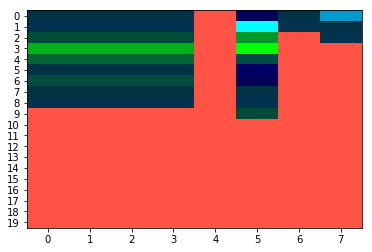

In [130]:
import matplotlib.pyplot as plt
plt.imshow(b,aspect='auto')
plt.xticks(np.arange(b.shape[1]))
plt.yticks(np.arange(b.shape[0]))
plt.show()

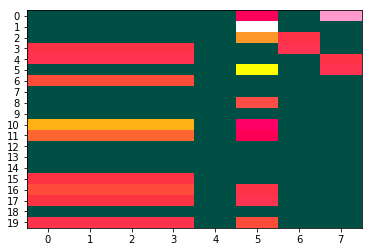

In [164]:
import matplotlib.pyplot as plt
plt.imshow(viz_mat,aspect='auto')
plt.xticks(np.arange(b.shape[1]))
plt.yticks(np.arange(b.shape[0]))
plt.show()

In [174]:
# Print viz mat for all items
file_input = "item_viz_2019-04-16_21_06_28.csv"
viz_matrices = pd.read_csv(file_input)


In [1]:
w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 5

# ax enables access to manipulate each of subplots
ax = []
for i in range(columns*rows):
    img = np.load(viz_matrices['viz_mat_fn'].iloc[i-1])
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(viz_matrices['item'].iloc[i-1])  # set title
    plt.imshow(img)

plt.show()  # finally, render the plot

NameError: name 'plt' is not defined